# Computing overall return period

In [ ]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [4]:
from pathlib import Path
from datetime import datetime
import os


import geopandas as gpd
import pandas as pd
import numpy as np
from src.constants import *
from src.utils import *
from src.datasources import imerg, codab

In [ ]:
# Lists of storm events
readiness_storms = ["FAVIO", "IRINA", "DINEO", "IDAI", "ELOISE"]
action_storms = [
    "FAVIO",
    "JOKWE",
    "DINEO",
    "IDAI",
    "ELOISE",
    "GOMBE",
    "FREDDY",
]
obs_ws_storms = ["DINEO", "IDAI", "ELOISE", "FREDDY", "FILIPO"]
obs_rain_storms = ["FAVIO", "ANA", "GOMBE", "FREDDY"]

df = storm_df.copy()

<Axes: >

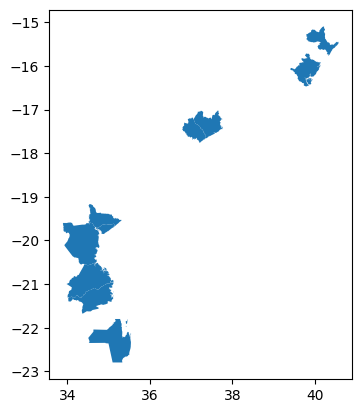

In [ ]:
# Sort the DataFrame by 'Total Affected' in descending order
# Round values in 'Total Affected' and 'CERF Allocations' columns
df_sorted = df.sort_values(by="Total Affected", ascending=False)

# Apply styling
styled_df = (
    df_sorted.style.map(
        highlight_true,
        subset=[
            "Readiness",
            "Action",
            "Observational Rainfall",
            "Observational Wind Speed",
        ],
    )
    .map(color_bar_affected, subset=["Total Affected"])
    .map(color_bar_cerf, subset=["CERF Allocations"])
    .format(
        {
            "Total Affected": lambda x: (
                f"{int(x):,}" if pd.notna(x) else ""
            ),  # Format with commas, no decimals, NaN as blank
            "CERF Allocations": lambda x: (
                f"{int(x):,}" if pd.notna(x) else ""
            ),  # Format with commas, no decimals, NaN as blank
        }
    )
]["name"].unique()
readiness_storms

In [112]:
# action
action_storms = mf_lr_on_land_adm2_df[
    ((mf_lr_on_land_adm2_df["lt_hour"] >= 6))
    & (mf_lr_on_land_adm2_df["lt_hour"] <= 72)
    & (
        (mf_lr_on_land_adm2_df["max_wind_kt"] >= 48)
        & (mf_lr_on_land_adm2_df["ADM2_PT"].isin(ADM2_48))
        | (mf_lr_on_land_adm2_df["max_wind_kt"] >= 64)
        & (mf_lr_on_land_adm2_df["ADM2_PT"].isin(ADM2_64))
    )
]["name"].unique()
action_storms

array(['ELOISE', 'FREDDY', 'GOMBE', 'IDAI'], dtype=object)

In [113]:
# observational
obs_ws_storms = mf_lr_on_land_adm1[
    ((mf_lr_on_land_adm1["lt_hour"] == 0))
    & (mf_lr_on_land_adm1["max_wind_kt"] >= (48))
]["name"].unique()
obs_ws_storms

array(['DINEO', 'FREDDY', 'GOMBE', 'IDAI'], dtype=object)

In [64]:
rain_df = pd.read_csv(
    AA_DATA_DIR
    / "public"
    / "processed"
    / "moz"
    / "daily_imerg_cyclone_landfall_fixed.csv"
)
imerg_data = rain_df[(rain_df["radius"] == 250)]
imerg_df = imerg_data[
    imerg_data["time_step"].isin([-1, 0, 1])
].copy()  # Create a copy to avoid warnings
# Ensure 'date' is in datetime format
imerg_df["date"] = pd.to_datetime(imerg_df["date"], format="%d/%m/%Y %H:%M")
# Create month_year column
imerg_df["year_month"] = imerg_df["date"].dt.to_period("M")
imerg_sum_df = (
    imerg_df.groupby(["storm", "year_month"])["median_precip"]
    .sum()
    .reset_index()
)

obs_rain_storms = imerg_sum_df[imerg_sum_df["median_precip"] >= 55][
    "storm"
].unique()
# rename IDAI 1 to IDAI
obs_rain_storms[obs_rain_storms == "IDAI 1"] = "IDAI"
obs_rain_storms

array(['ANA', 'DINEO', 'ELOISE', 'FREDDY', 'GOMBE', 'IDAI', 'KENNETH'],
      dtype=object)

Return Period for Readiness

In [40]:
num_years_storms = len(df_rsmc["season"].unique())
readiness_rate = len(readiness_storms) / num_years_storms
print(f"The readiness activation rate is {round(readiness_rate*100,1)}%")
print(
    f"The readiness return period is 1-in-{round(1/readiness_rate, 1)} years"
)

The readiness activation rate is 35.7%
The readiness return period is 1-in-2.8 years


Return Period for Action

In [41]:
action_rate = len(action_storms) / num_years_storms
print(f"The action activation rate is {round(action_rate*100,1)}%")
print(f"The action return period is 1-in-{round(1/action_rate, 1)} years")

The action activation rate is 28.6%
The action return period is 1-in-3.5 years


Return Period for Readiness + Action

There are no activities for readiness so usually looking at action. Using and instead of or here.

In [46]:
readiness_and_action_storms = [
    storm for storm in action_storms if storm in readiness_storms
]
readiness_and_action = len(readiness_and_action_storms) / num_years_storms
print(
    f"The readiness or action activation rate is {round(readiness_and_action*100,1)}%"
)
print(
    f"The readiness or action return period is 1-in-{round(1/readiness_and_action, 1)} years"
)

The readiness or action activation rate is 28.6%
The readiness or action return period is 1-in-3.5 years


Return Period for Observational : Wind Speed >= 48 knots

In [48]:
obs_ws_rate = len(obs_ws_storms) / num_years_storms
print(
    f"The observational wind speed activation rate is {round(obs_ws_rate*100,1)}%"
)
print(
    f"The observational wind speed return period is 1-in-{round(1/obs_ws_rate, 1)} years"
)

The observational wind speed activation rate is 28.6%
The observational wind speed return period is 1-in-3.5 years


Return Period for Observational : Rainfall >= 55 mm

In [65]:
num_years_storms_rain = 2023 - 2003 + 1
obs_rain_rate = len(obs_rain_storms) / num_years_storms_rain
print(
    f"The observational rainfall activation rate is {round(obs_rain_rate*100,1)}%"
)
print(
    f"The observational rainfall return period is 1-in-{round(1/obs_rain_rate, 1)} years"
)

The observational rainfall activation rate is 33.3%
The observational rainfall return period is 1-in-3.0 years


Return Period for Observational

In [124]:
obs_rain_storms

array(['ANA', 'DINEO', 'ELOISE', 'FREDDY', 'GOMBE', 'IDAI', 'KENNETH'],
      dtype='<U7')

In [120]:
observational_overlap = [
    storm for storm in obs_ws_storms if storm in obs_rain_storms
]

observational_rate = (
    obs_ws_rate + obs_rain_rate - (len(observational_overlap) / overlap_years)
)
print(
    f"The observational activation rate is {round(observational_rate*100,1)}%"
)
print(
    f"The observational return period is 1-in-{round(1/observational_rate, 1)} years"
)

The observational activation rate is 33.3%
The observational return period is 1-in-3.0 years


Return Period for Action OR Observational Wind Speed

In [131]:
action_obs_storms = [
    storm for storm in action_storms if storm in obs_ws_storms
]  # to get which overlap for readiness and action against observational
action_obs_ws_rate = (
    action_rate
    + obs_ws_rate
    - (
        len(action_obs_storms) / overlap_years
    )  # only dividing by years/seasons of overlap
)
print(
    f"The action or observational wind speed activation rate is {round(action_obs_ws_rate*100,1)}%"
)
print(
    f"The action or observational wind speed return period is 1-in-{round(1/action_obs_ws_rate, 1)} years"
)

The action or observational wind speed activation rate is 35.7%
The action or observational wind speed return period is 1-in-2.8 years


Return Period for Action OR Observational WS and Rainfall

In [135]:
action_obs_storms = [
    storm for storm in action_storms if storm in observational_overlap
]  # to get which overlap for readiness and action against observational
action_obs_rate = (
    action_rate
    + observational_rate
    - (
        len(action_obs_storms) / overlap_years
    )  # only dividing by years/seasons of overlap
)
print(
    f"The action or observational activation rate is {round(action_obs_rate*100,1)}%"
)
print(
    f"The action or observational return period is 1-in-{round(1/action_obs_rate, 1)} years"
)

The action or observational activation rate is 40.5%
The action or observational return period is 1-in-2.5 years
